In [ ]:
with open("../data/raw/contracts/cuad/cuad_data/CUADv1.json", "r", encoding="utf-8") as f:
    test_data = json.load(f)

print(type(test_data))
print(test_data.keys())

### Section: CUAD Clause Analysis

#### Load CUAD JSON

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.utils.cuad_loader import load_cuad, sample_cuad_entries
import pandas as pd
from pathlib import Path

cuad_path = Path("../data/raw/contracts/cuad/cuad_data/CUADv1.json")
entries = load_cuad(cuad_path)
print(f"Loaded {len(entries)} CUAD entries.")


Loaded 20910 CUAD entries.


####  Convert to DataFrame

In [2]:
df = pd.DataFrame(entries)
df.head()


,doc,question,answer,answer_start,context
0,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,Highlight the parts (if any) of this contract ...,DISTRIBUTOR AGREEMENT,44,EXHIBIT 10.6\n\n ...
1,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,Highlight the parts (if any) of this contract ...,Distributor,244,EXHIBIT 10.6\n\n ...
2,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,Highlight the parts (if any) of this contract ...,"7th day of September, 1999.",263,EXHIBIT 10.6\n\n ...
3,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,Highlight the parts (if any) of this contract ...,The term of this Agreement shall be ten (10)...,5268,EXHIBIT 10.6\n\n ...
4,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,Highlight the parts (if any) of this contract ...,The term of this Agreement shall be ten (10)...,5268,EXHIBIT 10.6\n\n ...


#### Count question types

In [3]:
df['question'].value_counts().head(10)

question
Highlight the parts (if any) of this contract related to "Document Name" that should be reviewed by a lawyer. Details: The name of the contract                                                                                                                                                                                                                                    510
Highlight the parts (if any) of this contract related to "Parties" that should be reviewed by a lawyer. Details: The two or more parties who signed the contract                                                                                                                                                                                                                   510
Highlight the parts (if any) of this contract related to "Agreement Date" that should be reviewed by a lawyer. Details: The date of the contract                                                                                                 

#### Keyword pattern matching

In [4]:
import re

def detect_keywords(text, keywords):
    matches = [kw for kw in keywords if re.search(rf"\b{re.escape(kw)}\b", text, re.IGNORECASE)]
    return ", ".join(matches)

keywords = ["termination", "governing law", "indemnity", "payment", "confidentiality"]
df['matched_keywords'] = df['question'].apply(lambda q: detect_keywords(q, keywords))
df[['question', 'matched_keywords']].sample(10)


,question,matched_keywords
10784,Highlight the parts (if any) of this contract ...,
1516,Highlight the parts (if any) of this contract ...,
15697,Highlight the parts (if any) of this contract ...,
17453,Highlight the parts (if any) of this contract ...,
11876,Highlight the parts (if any) of this contract ...,
19777,Highlight the parts (if any) of this contract ...,termination
18198,Highlight the parts (if any) of this contract ...,
7636,Highlight the parts (if any) of this contract ...,
17401,Highlight the parts (if any) of this contract ...,
7419,Highlight the parts (if any) of this contract ...,


#### Visualize distribution

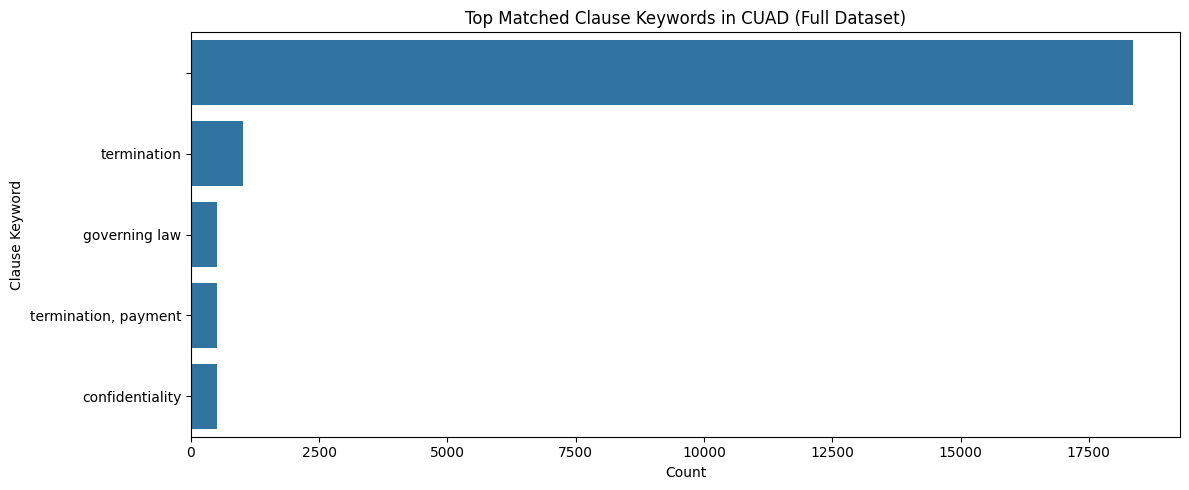

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))
sns.countplot(data=df, y='matched_keywords', order=df['matched_keywords'].value_counts().index)
plt.title("Top Matched Clause Keywords in CUAD (Full Dataset)")
plt.xlabel("Count")
plt.ylabel("Clause Keyword")
plt.tight_layout()
plt.show()


In [6]:
output_path = Path("../data/processed/cuad_flat")
output_path.mkdir(parents=True, exist_ok=True)

df.to_csv(output_path / "cuad_clauses.csv", index=False)


In [7]:
# Extract quoted clause label from question

def extract_clause_type(question):
    match = re.search(r'"([^"]+)"', question)
    if match:
        return match.group(1).strip()
    return "unknown"

def normalize_clause_type(label):
    return label.lower().replace(" ", "_").replace("-", "_")

df["clause_type_raw"] = df["question"].apply(extract_clause_type)
df["clause_type"] = df["clause_type_raw"].apply(normalize_clause_type)

# Quick sample
df[["question", "clause_type"]].sample(10)


,question,clause_type
4974,Highlight the parts (if any) of this contract ...,no_solicit_of_employees
10585,Highlight the parts (if any) of this contract ...,governing_law
13546,Highlight the parts (if any) of this contract ...,rofr/rofo/rofn
18501,Highlight the parts (if any) of this contract ...,exclusivity
16335,Highlight the parts (if any) of this contract ...,change_of_control
18787,Highlight the parts (if any) of this contract ...,non_compete
4647,Highlight the parts (if any) of this contract ...,non_disparagement
5249,Highlight the parts (if any) of this contract ...,parties
2463,Highlight the parts (if any) of this contract ...,effective_date
7996,Highlight the parts (if any) of this contract ...,parties


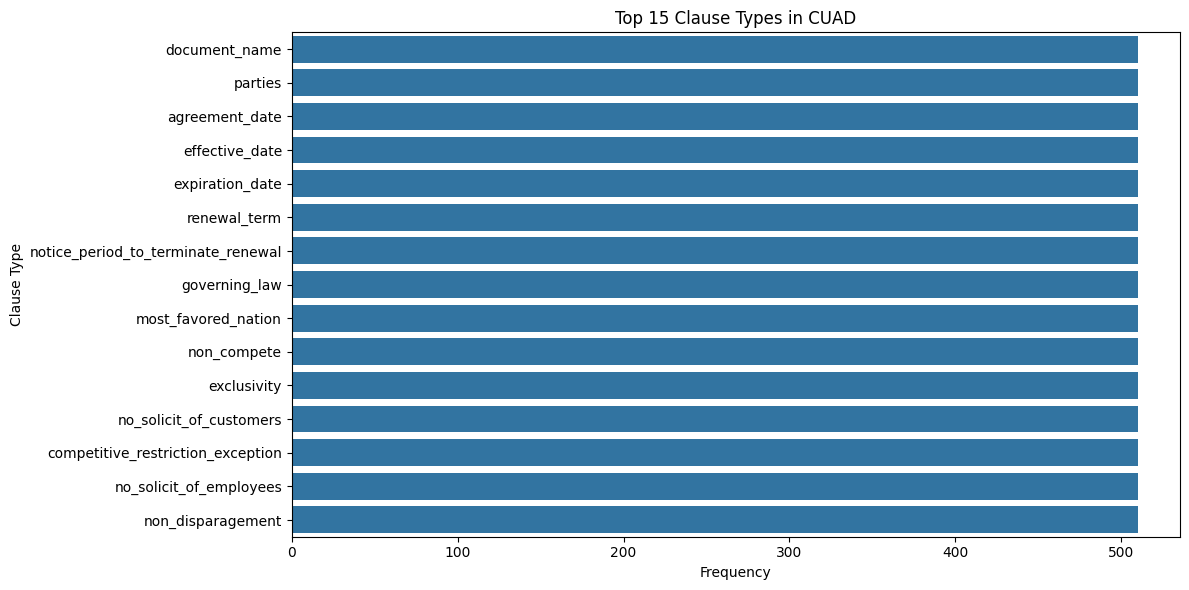

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(data=df, y="clause_type", order=df["clause_type"].value_counts().index[:15])
plt.title("Top 15 Clause Types in CUAD")
plt.xlabel("Frequency")
plt.ylabel("Clause Type")
plt.tight_layout()
plt.show()


In [9]:
export_path = Path("../data/processed/cuad_flat")
export_path.mkdir(parents=True, exist_ok=True)

df[["doc", "clause_type", "question", "answer", "answer_start", "context"]].to_csv(export_path / "cuad_clauses_labeled.csv", index=False)


In [11]:
# Step 1: Define a clause-to-template mapping
clause_template_map = {
    "governing_law": "governing-law-clause",
    "confidentiality": "confidentiality-agreement",
    "exclusivity": "exclusive-supply-agreement",
    "termination_for_convenience": "termination-clause",
    "effective_date": "effective-date",
    "expiration_date": "expiration-date",
    "renewal_term": "term-renewal-clause",
    "no_solicit_of_employees": "non-solicitation-clause",
    "non_disparagement": "non-disparagement-clause",
    "non_compete": "non-compete-agreement",
    "most_favored_nation": "mfn-clause",
    "agreement_date": "agreement-date",
    "document_name": "document-identity",
    "parties": "party-identification",
    "no_solicit_of_customers": "non-solicitation-customers",
    "competitive_restriction_exception": "competition-restriction-exceptions",
    "change_of_control": "change-of-control-clause",
    "license_grant": "license-grant-clause",
    "audit_rights": "audit-rights-clause",
    "liquidated_damages": "liquidated-damages-clause",
    "cap_on_liability": "liability-cap-clause",
    "minimum_commitment": "minimum-commitment-clause",
    "anti_assignment": "assignment-clause",
    "volume_restriction": "volume-limitation-clause",
    "source_code_escrow": "escrow-clause",
    "insurance": "insurance-obligation-clause"

    
}

def match_template(clause_type):
    return clause_template_map.get(clause_type, "unmapped")

df["cicero_template"] = df["clause_type"].apply(match_template)
df[["clause_type", "cicero_template"]].drop_duplicates().sort_values(by="clause_type")


,clause_type,cicero_template
28,affiliate_license_licensee,unmapped
27,affiliate_license_licensor,unmapped
2,agreement_date,agreement-date
18,anti_assignment,assignment-clause
33,audit_rights,audit-rights-clause
35,cap_on_liability,liability-cap-clause
17,change_of_control,change-of-control-clause
12,competitive_restriction_exception,competition-restriction-exceptions
39,covenant_not_to_sue,unmapped
0,document_name,document-identity
